# Decaying prompt control signal in text generation with Mistral 7B Instruct

This notebook demonstrates with experiments how the control signal of instruction prompt decays as the distance increases between the prompt and the generated text. In the experiments, a 7B-parameter instruction-tuned language model is first prompted with the task description along with some examples to generate stories with a strong positive sentiment. The idea of this few-shot setting is to leverage in-context learning, where the model would learn from the examples the task of generating stories with positive sentiment. After providing the model with this control prompt, we let the model to generate continuations to varying lengths of pre-generated stories with strong negative sentiments. Starting from no additional context until 200 tokens of negative story, we let the model generate story continuations for 100 tokens for each story beginning. The target of the experiments is to see whether the prompt signal instructing a positive sentiment for the story decreases as the length of the story beginning with negative sentiment increases. To measure the strength of the control signal, we will use a sentiment classifier to assess probability of positive sentiment for the generated story continuation. 

As the dataset for obtaining the story beginnings, we will be using the WritingPrompts dataset [1]. The dataset is originally collected from Reddit's [WritingPrompts forum](https://www.reddit.com/r/WritingPrompts/), where users can respond with stories to story prompts provided by other users.

### Experiment setup
Text Generation Model: [Mistral 7B Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1) (7B parameters)<br>
Sentiment Classifier Model: [Twitter-roBERTa-base for Sentiment Analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest) (125M parameters)<br>
Dataset: [WritingPrompts](https://github.com/facebookresearch/fairseq/blob/main/examples/stories/README.md)

## Experiments
We start by first installing the needed libraries. We will use [Hugging Face](https://huggingface.co/) for downloading the pre-trained models, Mistral 7B Instruct and fine-tuned RoBERTa, and [PyTorch](https://pytorch.org/) for some additional data processing stuff.

In [27]:
%pip install torch transformers numpy matplotlib bitsandbytes accelerate scipy

In [1]:
import torch
from transformers import AutoTokenizer, GenerationConfig, AutoModelForSequenceClassification, AutoModelForCausalLM, BitsAndBytesConfig
from torch.nn.functional import softmax
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
import json
import os

hf_token = os.environ.get("HF_TOKEN")
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

### Data pre-processing
After importing the libraries, we will download the dataset and preprocess it for the experiments. To download the dataset, we follow the instructions given in the [README.md](https://github.com/facebookresearch/fairseq/blob/main/examples/stories/README.md) of the Hierarchical Neural Story Generation, which is the paper where the WritingPrompts dataset was presented.

In [ ]:
!curl https://dl.fbaipublicfiles.com/fairseq/data/writingPrompts.tar.gz | tar xvzf -

We will use the stories in the test dataset for the story beginnings as it is the smallest to load into memory and covers enough stories for our experiments. We will replace the special character `<newline>` in the stories to the more traditional `\n` to represent a new line.

In [2]:
def load_file(filename: str, encoding="utf-8") -> list[str]:
    with open(filename, "r", encoding=encoding) as f:
        return f.readlines()

In [3]:
test_stories = load_file("writingPrompts/test.wp_target")
test_stories = [story.replace("<newline>", "\n").strip() for story in test_stories]
print(f"Number of test stories: {len(test_stories)}")

Number of test stories: 15138


As we want to maximize the signal in the story beginnings to the opposite direction of the control signal, we will select as stories from the test dataset only those that have a strong negative sentiment. In addition, for the few-shot examples given in the prompt for the model we want to include stories that have a strong positive sentiment. To obtain this filtering, we will use the same sentiment classifier as we use for measuring the positive sentiment of the generated text; [Twitter-roBERTa-base for Sentiment Analysis](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest). As the threshold probability for indicating a strong negative sentiment, we will use 0.85, which was found to capture enough stories for the experiments with clear negative sentiments. As the threshold probability for positive sentiment, we will use a bit higher value, 0.95, as we need only a few examples in the prompt.

In [5]:
sentiment_model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name, num_labels=3).to(torch_device)
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
@torch.no_grad()
def get_sentiment_probabs(batch: np.ndarray[str]) -> torch.Tensor:
    inputs = sentiment_tokenizer(batch, return_tensors="pt", truncation=True, max_length=512, padding="max_length").to(torch_device)
    outputs = sentiment_model(**inputs)
    return softmax(outputs.logits, dim=1)

In [ ]:
def filter_negative_stories(stories: list[str], neg_threshold: float, pos_threshold: float, batch_size: int) -> tuple[list[str], list[str]]:
    negative_stories=[]; positive_stories=[]; i=0
    total_batches = len(stories) // batch_size; batch_times = []; start_time = time.time()

    while i+batch_size < len(stories):
        batch_start_time = time.time(); current_batch_num = i//batch_size+1; batches_left = total_batches - current_batch_num

        if i == 0:
            print(f"Batch {current_batch_num}/{total_batches}...", end="\r")
        else:
            print(f"Batch {current_batch_num}/{total_batches}... [estimated time {np.mean(batch_times) * batches_left / 60:0.2f} min] \
                   - Current status: {len(negative_stories)} negative stories, {len(positive_stories)} positive stories", end="\r")

        batch = stories[i:i+batch_size]
        sentiments = get_sentiment_probabs(batch)

        negative_indeces = (sentiments[:, 0] > neg_threshold).nonzero()
        for idx in negative_indeces:
            negative_stories.append(batch[idx])

        positive_indeces = (sentiments[:, 2] > pos_threshold).nonzero()
        for idx in positive_indeces:
            positive_stories.append(batch[idx])

        i += batch_size
        batch_end_time  = time.time(); batch_time = batch_end_time - batch_start_time; batch_times.append(batch_time)

    batch = stories[i:]
    sentiments = get_sentiment_probabs(batch)

    negative_indeces = (sentiments[:, 0] > neg_threshold).nonzero()
    for idx in negative_indeces:
        negative_stories.append(batch[idx])

    positive_indeces = (sentiments[:, 2] > pos_threshold).nonzero()
    for idx in positive_indeces:
        positive_stories.append(batch[idx])

    end_time = time.time()
    print(f"Total time: {(end_time - start_time) / 60} min \
          - Final status: {len(negative_stories)} negative stories, {len(positive_stories)} positive stories{' '*20}", end="\r")
    return negative_stories, positive_stories

In [ ]:
negative_stories, positive_stories = filter_negative_stories(test_stories, neg_threshold=0.85, pos_threshold=0.95, batch_size=128)

As filtering the stories from the test data took quite long, we will store these stories to disk.

In [ ]:
with open("artifacts/data/negative_stories.json", "w") as f:
    json.dump({"stories": negative_stories}, f)

with open("artifacts/data/positive_stories.json", "w") as f:
    json.dump({"stories": positive_stories}, f)

Let's print some of the positive and negative stories to see whether they seem to contain the right sentiments.

In [7]:
with open("artifacts/data/negative_stories.json", "r") as f:
    negative_stories = json.load(f)["stories"]

with open("artifacts/data/positive_stories.json", "r") as f:
    positive_stories = json.load(f)["stories"]

print("Positive stories:")
for i, example in enumerate(positive_stories[:3]):
    print(f"Example {i+1}: {example[:120]}... [{len(example)} chars]")

print("\n", "="*80, "\n")

print("Negative stories:")
for i, example in enumerate(negative_stories[:3]):
    print(f"Example {i+1}: {example[:120]}... [{len(example)} chars]")

Positive stories:
Example 1: `` Oh wow ! my own dragon . This is great we will have lots of fun , waiting for him to be large enough for me to fly hi... [591 chars]
Example 2: I love her , she is so special , yet broken , kinda like me . I remember the day I met her as it was yesterday , pheraps... [1442 chars]
Example 3: I 've always loved the night . The stillness . The cold . The silence . The perfect time for me to stalk . And from my s... [787 chars]


Negative stories:
Example 1: `` You fucking ... I did n't even say ... what were you walking , '' and he throws another stumbling madman jab . 
 
 
 ... [3026 chars]
Example 2: I fucked up . I kicked the mirror over -- a mirror I paid $ 500 to see . It showed no one . Just me . 
 
 Before I could... [2028 chars]
Example 3: 3,000 years have I been fighting . 
 
 Every morning , the raccoons scratch at my eyes . Every evening , the skunks spra... [1135 chars]


### Evaluation
Now that we have the stories pre-processed for the evaluation phase, we can continue to conduct the actual experiments. The language model used in the text generations is the [Mistral 7B Instruct model](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.1) and to save memory resources during the experiments, we will utilize quantization of the model. More specifically, we will use the LLM.Int() 8-bit quantization provided by [bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index), which effectively halves the memory footprint of our half-precision baseline model (bfloat16) without notable performance degradations. In the text generations we will utilize top-k sampling with 40 tokens being the value for the cut-off k. For the new stories we will generate only 100 tokens in total to save computing resources.

In [9]:
llm_model_name = "mistralai/Mistral-7B-Instruct-v0.1"
llm_tokenizer = AutoTokenizer.from_pretrained(llm_model_name, token=hf_token)

In [ ]:
quant_config = BitsAndBytesConfig(load_in_8bit=True)
llm_model = AutoModelForCausalLM.from_pretrained(
    llm_model_name,
    quantization_config=quant_config,
    device_map = "auto"
    )

In [8]:
generation_config = GenerationConfig(
    max_new_tokens=100,
    do_sample=True,
    top_k=40
)

The experimental setup will consist of generation tasks for the model using the negative stories as the beginning for the stories. For each negative story in our previously collected dataset, we will append tokens to the prompt in increments of 10 tokens from 0 until 200 total tokens. The model is then tasked in the prompt to continue these stories with the opposite sentiment, i.e., positive. To help the model in this task by leveraging in-context learning, we will also include few-shot examples to the prompt of similar pairs of instructions and positive stories. For each continuation for the story the model generates, we will measure the sentiment by using the same RoBERTa-based sentiment classifier as used previously when collecting the positive and negative story datasets. These measurements will then later be used for assessing the controllability of the text generation as the context length grows with the opposite control signal (i.e., negative story).

We will start by reading the datasets from the disk, tokenizing the negative stories for the Mistral 7B Instruct model and filtering out those with less than 200 tokens. In addition, for consistency and to save computing resources, we will select from the positive stories three stories that show a strong positive sentiment with a story-like narrative, and extract first sentences from them as the few-shot examples.

In [10]:
neg_story_tokens = [llm_tokenizer.encode(story, truncation=True, max_length=201) for story in negative_stories]
neg_story_tokens = torch.tensor([story[1:] for story in neg_story_tokens if len(story) == 201]) # remove first token (<s>)
neg_story_tokens = neg_story_tokens[:48, :] # 48 negative stories is enough for our experiments (save on compute)
print(f"Shape of tokenized negative stories tensor: {neg_story_tokens.shape}")

Shape of tokenized negative stories tensor: torch.Size([48, 200])


In [11]:
positive_example1 = positive_stories[14][:805]
positive_example2 = positive_stories[15][:662]
positive_example3 = positive_stories[23][:848]
print(f"Positive example 1: {positive_example1[:120]}... [{len(positive_example1)} chars]")
print(f"Positive example 2: {positive_example2[:120]}... [{len(positive_example2)} chars]")
print(f"Positive example 3: {positive_example3[:120]}... [{len(positive_example3)} chars]")

Positive example 1: It was a fine morning . Absolutely stunning . My view of the sunrise from my room was amazing ! And not to mention the s... [805 chars]
Positive example 2: The terrace was absolutely stunning , though I had sat in it too many times to be breathtaken by its clean air and flora... [662 chars]
Positive example 3: Thomas Hendricks was excited . No , that would be an understatement . Thomas Hendricks was ecstatic . He was over the mo... [848 chars]


Then we will create and tokenize the prompt with the positive examples and test the prompt on the model to check that the model understands the task and the prompt works as expected. In the prompt, we will add the instruction between [INST] and [/INST] tokens (they are actually encoded as normal strings and not as special tokens, not sure why Mistral made this design decision) as instructed by the [Mistral Tokenization documentation](https://docs.mistral.ai/guides/tokenization/). We will use three examples in total as the few-shot examples for the model. The instruction in the prompt includes an exaggerated positive sentiment to maximize the control signal. In addition, the addition of "one and only one" ensures that the model generates only one story as initially the model often started to generate multiple stories.

In [12]:
prompt = f"""
[INST] Write one and only one overly positive story with as merry happy jolly joyful cheerful and optimistic tone as possible.
Below are some examples:

Story: {positive_example1}

Story: {positive_example2}

Story: {positive_example3}
[/INST] Story:"""

tokenized_prompt = llm_tokenizer.encode(prompt, return_tensors="pt").to(torch_device)

In [12]:
with torch.no_grad():
    outputs = llm_model.generate(tokenized_prompt, generation_config=generation_config)
generated_text = llm_tokenizer.decode(outputs[0], skip_special_tokens=False)
print(generated_text)

<s> 
[INST] Write one and only one overly positive story with as merry happy jolly joyful cheerful and optimistic tone as possible.
Below are some examples:

Story: It was a fine morning . Absolutely stunning . My view of the sunrise from my room was amazing ! And not to mention the smells ! My mother made my favourite breakfast . Under the lid of my tray lay a stack of thin pancakes , with a side of buttered bread with dark green sprinkles ! Right next to my tray was a cup of orange juice , and although I had just rinsed my mouth with my favourite cherry mouthwash , it tasted just as it should ! Damien , my only brother , was a bit startled when my mother set his tray down , because he always takes a second to remember things and people when he wakes up . Even though he was scared for a second , he thanked her for the most important meal of the day . Really , we did n't have much food that was n't breakfast , but I do n't mind . Everyone likes breakfast .

Story: The terrace was absol

Based on the generated text, the prompt seems to work nicely and the model understands the task to generate a positive story. Next we can use this prompt and the negative stories to conduct the main experiment as described previously. We will start by generating the continuations to the stories generated by the model. As we are limited by the GPU memory, we will use a batch size of 8, resulting in total of 6 batches. 

In [13]:
batch_size = 8
tokenized_prompt = tokenized_prompt.expand(batch_size, -1) # expand prompt to shape (batch_size x prompt_length)
tokenized_prompt_size = tokenized_prompt.shape[1]

start_time = time.time()
for batch in range(0, neg_story_tokens.shape[0], batch_size):
  batch_neg_story_tokens = neg_story_tokens[batch:batch+batch_size, :].to(torch_device)
  batch_sample_texts = []
  for num_tokens in range(0, 210, 10):
      print(f"Batch {batch//batch_size}: Generating story continuations for {num_tokens} tokens [{(time.time()-start_time) / 60:0.2f} min since start]")
      if num_tokens > 0:
          inputs = torch.concat((tokenized_prompt, batch_neg_story_tokens[:, :num_tokens]), dim=1)
      else:
          inputs = tokenized_prompt

      with torch.no_grad():
          outputs = llm_model.generate(inputs, generation_config=generation_config)

      generated_outputs = outputs[:, tokenized_prompt_size + num_tokens:]
      sample_texts = llm_tokenizer.batch_decode(generated_outputs, skip_special_tokens=True)
      batch_sample_texts.append(sample_texts)

  with open(f"generations_batch_{batch//batch_size}.json", "w") as f:
      json.dump({"generations": batch_sample_texts}, f)

Batch 0: Generating story continuations for 0 tokens [0.00 min since start]
Batch 0: Generating story continuations for 10 tokens [0.68 min since start]
Batch 0: Generating story continuations for 20 tokens [1.35 min since start]
Batch 0: Generating story continuations for 30 tokens [2.01 min since start]
Batch 0: Generating story continuations for 40 tokens [2.68 min since start]
Batch 0: Generating story continuations for 50 tokens [3.34 min since start]
Batch 0: Generating story continuations for 60 tokens [4.02 min since start]
Batch 0: Generating story continuations for 70 tokens [4.70 min since start]
Batch 0: Generating story continuations for 80 tokens [5.36 min since start]
Batch 0: Generating story continuations for 90 tokens [6.03 min since start]
Batch 0: Generating story continuations for 100 tokens [6.71 min since start]
Batch 0: Generating story continuations for 110 tokens [7.37 min since start]
Batch 0: Generating story continuations for 120 tokens [8.03 min since star

Next we will conduct the sentiment analysis step to obtain the sentiment measurements of the text generations with varying lengths of story beginnings.

In [35]:
all_probabs = {f"{num_tokens}": [] for num_tokens in range(0, 210, 10)}
batch_size = 8

num_batches = neg_story_tokens.shape[0] // batch_size
for i in range(num_batches):
    with open(f"artifacts/data/generations_batch_{i}.json", "r") as f:
        generation_data_batch = json.load(f)

    for num_tokens in range(0, 210, 10):
        sentiment_probabs = get_sentiment_probabs(generation_data_batch["generations"][num_tokens//10])
        pos_probabs = sentiment_probabs[:, 2].tolist()
        all_probabs[f"{num_tokens}"].extend(pos_probabs)

We can then save these probabilities to disk as well for further analysis.

In [42]:
with open("artifacts/data/pos_probabs.json", "w") as f:
    json.dump(all_probabs, f)

### Analysis
Next we analyze the obtained results to identify whether the additional context with opposite signal to the control signal has any effect on the controllability of the text generation.

In [55]:
with open("artifacts/data/pos_probabs.json", "r") as f:
    all_probabs = json.load(f)

probabs = torch.zeros((21, neg_story_tokens.shape[0]))
for num_tokens in range(0, 210, 10):
    probabs[num_tokens//10, :] = torch.tensor(all_probabs[f"{num_tokens}"])
print(f"Shape of probability tensor: {probabs.shape}")

Shape of probability tensor: torch.Size([21, 48])


We can first plot the averaged probabilities for positive sentiment of the story continuations.

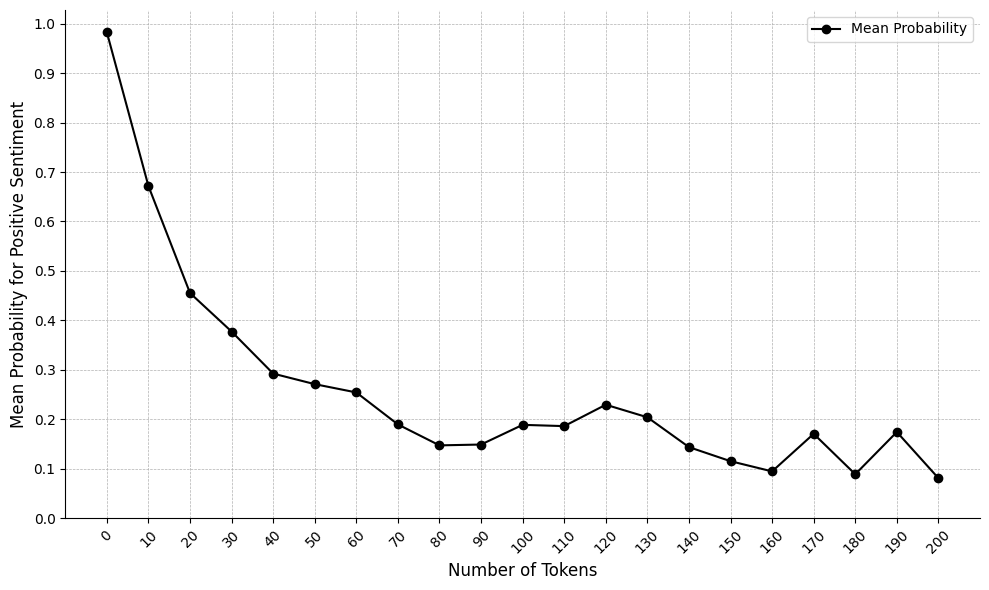

In [54]:
means = probabs.mean(dim=1)

plt.figure(figsize=(10, 6))
plt.plot(range(0, 210, 10), means, marker="o", linestyle="-", color="black", label="Mean Probability")
plt.xlabel("Number of Tokens", fontsize=12)
plt.ylabel("Mean Probability for Positive Sentiment", fontsize=12)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.xticks(range(0, 210, 10), rotation=45)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.tight_layout()

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


From the plot we can see that there seems to be a strong relationship between the number of tokens of the negative story used as the start of the story and the positive sentiment of the story continuation. The relationship seems to be an exponentially decreasing function, interesting. We can then assess the significance of this relationship by using Pearson correlation coefficient.

In [59]:
pearson_corr, p_value = stats.pearsonr(means.tolist(), list(range(0, 210, 10)))
print(f"Pearson correlation: {pearson_corr}, p-value: {p_value}")

Pearson correlation: -0.749555015094709, p-value: 9.176368154419822e-05


From the obtained Pearson correlation we can see that indeed the number of tokens between the instruction prompt and the generated text, and the positive sentiment of the generated text are negatively correlated with statistical significance.

### Discussion

The results of the experiments indicate that the control signal from the instruction prompt decreases when additional context is added between the control prompt and the generated text. This is shown by the negative correlation between the number of tokens added from the negative stories after the prompt and the measured positive sentiment of the generated story continuation. It seems that as the context gets filled with a story with strong negative sentiment, the LLM "forgets" the initial instruction to generate an overly positive story and continues to generate a story similar to the negative story closest to it in the context window.

The phenomenon shown here is a major downside of using prompting as the only method for controlled text generation. For example, users of some chatbots might have extremely long conversations with token sizes of multiple times the 200 tokens used as the upper boundary in this paper, and the model should be able to follow the initial instructions throughout this whole conversation. What is especially surprising and alarming in the results of this paper is how quickly the control signal decays as context guiding the model in the opposite direction is added. Only after 20 tokens the measured positive sentiment of the text generation is halved. This indicates that the model is extremely biased toward the closest tokens in its generations as the prompt used for controlling the model is 627 tokens long.

There are some limitations of the study presented here. First of all, the model used in the experiments contains only 7 billion parameters, and it is possible that prompting works much better for controlling text generation with larger models. In addition, the sample size is still relatively small with only 48 story continuations covered. Finally, sentiment control can be seen only as a toy example of real-world controlled text generation tasks and, therefore, might overly simplify some of the results.